# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name,"\n\n", brain)

BananaBrain 

 Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


# agent

In [6]:
import torch
import torch.nn as nn

import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.layers = nn.ModuleList(
            [
                nn.Linear(state_size, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
#                 nn.Linear(64, 32),
#                 nn.ReLU(),
                nn.Linear(64, action_size),
            ]
        )

    def forward(self, state):
        x = self.layers[0](state)
        for layer in self.layers[1:]:
            x = layer(x)
        return x


In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64  # minibatch size
GAMMA = 0.99  # discount factor
TAU = 1e-3  # for soft update of target parameters
LR = 5e-4  # learning rate
UPDATE_EVERY = 4  # how often to update the network


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [41]:
def npToFloatTensor(a, device):
    return torch.from_numpy(a).float().to(device)


def npToLongTensor(a, device):
    return torch.from_numpy(a).long().to(device)


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(
            state_size, action_size, BUFFER_SIZE, BATCH_SIZE, seed, self.device
        )
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory

        self.memory.add(state, action, reward, next_state, done)
        # print("self.memory.add", state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # print(actions)
        with torch.no_grad():
            estimatedQVaFromLocal = self.qnetwork_local.forward(next_states)
            bestActionIndices = estimatedQVaFromLocal.argmax(1).unsqueeze(1)
            estimatedQValFromTarget = estimatedQVaFromLocal.gather(1, bestActionIndices)
            Q_targets = rewards + (gamma * estimatedQValFromTarget * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params,
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.insert_index = 0
        self.buffer_full = False
        self.batch_size = batch_size

        self.seed = random.seed(seed)
        self.device = device

        self.states = torch.zeros(buffer_size, state_size).to(device)
        self.next_states = torch.zeros(buffer_size, state_size).to(device)
        self.actions = torch.zeros(buffer_size, 1).long().to(device)
        self.rewards = torch.zeros(buffer_size, 1).to(device)
        self.dones = torch.zeros(buffer_size, 1).to(device)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        obs = self.insert_index
        dev = self.device

        self.states[obs, :] = npToFloatTensor(state, dev)
        self.next_states[obs, :] = npToFloatTensor(next_state, dev)
        self.actions[obs, :] = npToLongTensor(np.array(action), dev)
        self.rewards[obs, :] = npToFloatTensor(np.array(reward), dev)
        self.dones[obs, :] = npToFloatTensor(np.array(1.0*done), dev)
        if obs == (BUFFER_SIZE - 1):
            self.buffer_full = True
            self.insert_index = 0
        self.insert_index += 1

    def sample(self):
        # sample *with replacement*
        bufferSizeSoFar = BUFFER_SIZE if self.buffer_full else self.insert_index
        randomInds = (
            torch.LongTensor(BATCH_SIZE - 1).random_(0, bufferSizeSoFar).to(self.device)
        )

        states = self.states.index_select(0, randomInds)
        actions = self.actions.index_select(0, randomInds)
        rewards = self.rewards.index_select(0, randomInds)
        next_states = self.next_states.index_select(0, randomInds)
        dones = self.dones.index_select(0, randomInds)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return BUFFER_SIZE if self.buffer_full else self.insert_index


In [43]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time


def runner(
    env,
    agent,
    agent_name,
    solution_score,
    train=True,
    n_episodes=2000,
    max_t=1000,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay=0.995,
    round_num=0,
    update_plot_every=10
):
    t0 = time.time()

    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_rolling_avg = []
    steps_in_episode = []

    eps = eps_start  # initialize epsilon
    elapsed_time = []
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=train)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0 
#         state = env.reset()
#         score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
#             print(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished 
            score += reward                                # update the score
            
            if train:
                agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
                

        steps_in_episode.append(t)

        print("episode lasted {} steps".format(t))
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        rolling_avg = np.mean(scores_window)
        scores_rolling_avg.append(rolling_avg)
        elapsed_time.append(time.time() - t0)

        eps = max(eps_end, eps_decay * eps)  # decrease epsilon

        if i_episode % update_plot_every == 0:
            # plot it
            plt.cla()
            titleStr = "{} -- round {}\nEpisode {}, ({:.2f}s, {:.2f}s/episode)\nAverage Score: {:.2f}".format(
                agent_name,
                round_num,
                i_episode,
                time.time() - t0,
                (time.time() - t0) / i_episode,
                rolling_avg,
            )
            plt.title(titleStr)
            plt.plot(scores)
            plt.plot(scores_rolling_avg)
            plt.ylabel("Score")
            plt.xlabel("Episode #")
            plt.xlim(0, n_episodes)  # consistent scale
            display.clear_output(wait=True)
            display.display(plt.gcf())
    if np.mean(scores_window) >= solution_score:
        print(
            "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                i_episode - 100, np.mean(scores_window)
            )
        )
        torch.save(agent.qnetwork_local.state_dict(), "bananas_ddqn_naive-prioritized-replay.pth")
    return (scores, elapsed_time, steps_in_episode, agent.qnetwork_local.state_dict())


In [44]:
agentArgs = {
   'device': device,
   'state_size': state_size,
   'action_size': action_size,
   'seed': 0
}
bananaAgent = Agent(**agentArgs)

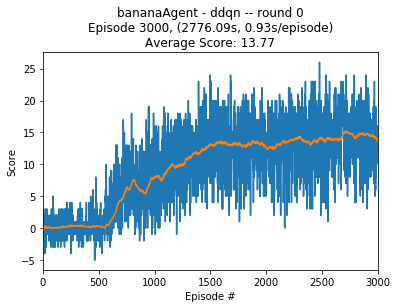


Environment solved in 2900 episodes!	Average Score: 13.77


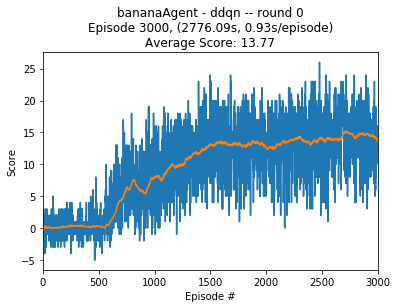

In [45]:
N_EPISODES = 3000

scores, elapsed_time, steps_in_episode, agent_state_dict = runner(
    env, 
    bananaAgent, 
    "bananaAgent - ddqn",
    13,
    n_episodes=N_EPISODES,
    max_t=1000
)

When finished, you can close the environment.

In [ ]:
env.close

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent

In [5]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
def dqn(agent, n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True):
    """Deep Q-Learning.
    
    Args
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): flag deciding if the agent will train or just play through the episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_dqn.pth')
            break
    return scores

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn(agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.08
Episode 200	Average Score: 0.50
Episode 300	Average Score: 1.42
Episode 400	Average Score: 2.38
Episode 500	Average Score: 3.10
Episode 600	Average Score: 4.06
Episode 620	Average Score: 4.51

KeyboardInterrupt: 

In [8]:
env.close()